In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import cv2
from skimage import color

from pathlib import Path
import os
basePath = Path(os.getcwd()).parent

# Prework

The is the color feature generature code initially implemented for the Section 4.5, "Evaluating Results from one Downstream Application: Growth Curve of Strawberries", of the paper: Junhan Wen, Camiel R. Verschoor, Chengming Feng, Irina-Mona Epure, Thomas Abeel, Mathijs de Weerdt. *"The Growing Strawberries Dataset: Tracking Multiple Objects with Biological Development over an Extended Period."* 2024 IEEE/CVF Winter Conference on Applications of Computer Vision (WACV), 2024. https://doi.org/10.1109/WACV57701.2024.00695

The following analysis of the color features of the SDS dataset () and KGCVS dataset () used the same code.

In [ ]:
%run ../functions/color_feature_gen.py

# Quality prediction dataset

The dataset is accessible via:

Wen, Junhan; de Weerdt, Mathijs; Thomas Abeel; Camiel Verschoor; LIsanne Schuddebeurs et. al. (2023): Data underlying the research of Quality prediction of strawberries with RGB image segments. Version 2. 4TU.ResearchData. dataset. https://doi.org/10.4121/21864590.v2

When using, please cite the dataset and the paper: Wen, Junhan, Abeel, Thomas, and De Weerdt, Mathijs. “How sweet are your strawberries?”: Predicting sugariness using non-destructive and affordable hardware. *Frontiers in Plant Science*, vol. 14, pp. 1160645, 2023. Frontiers Media SA. https://doi.org/10.3389/fpls.2023.1160645

In [15]:
df = pd.read_csv(os.path.join(basePath.parent, \
                              'Data/Quality_Prediction/Strawberry_Measurements_with_Seg_Connections_mtd1.csv'))
df.head()

,Strawberry_ID,Marketable,Ripeness,Size Class,Sugariness,Firmness,RGB_Camera,frame_key,segment_file
0,"5,5,1,1",1.0,9.0,Small (25-30 mm),10.8,NaN,1,0506_0856,0506_0856_5-5-1-1.png
1,"5,5,1,2",1.0,9.0,Small (25-30 mm),11.1,NaN,1,0506_0856,0506_0856_5-5-1-2.png
2,"5,5,1,3",1.0,9.0,Coarse (> 30mm),10.3,NaN,1,0506_0856,0506_0856_5-5-1-3.png
3,"5,5,1,4",1.0,9.0,Small (25-30 mm),9.8,NaN,1,0506_0856,0506_0856_5-5-1-4.png
4,"5,5,1,5",1.0,9.0,Small (25-30 mm),13.9,NaN,1,0506_0856,0506_0856_5-5-1-5.png


In [16]:
res = []
for i in range(len(df)):
    seg_file = df['segment_file'][i]
    seg_img = cv2.imread(os.path.join(basePath.parent, 'Data/Quality_Prediction/Segments', seg_file))

    arr = seg_img.reshape(-1,3)
    mask = np.all(arr == 0, axis=1)
    filtered_array = arr[~mask]

    a_star = color.rgb2lab(filtered_array).transpose().mean(axis=1)[1]
    res.append([df['Ripeness'][i],a_star])

res = np.array(res)

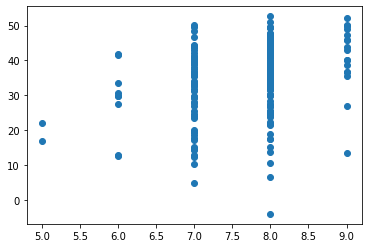

In [18]:
plt.scatter(res[:,0], res[:,1])

# SDS

In [ ]:
res_sds = np.load(os.path.join(basePath,'example_data/SDS_train.npy'))

Text(0.5, 0, 'Label of dataset')

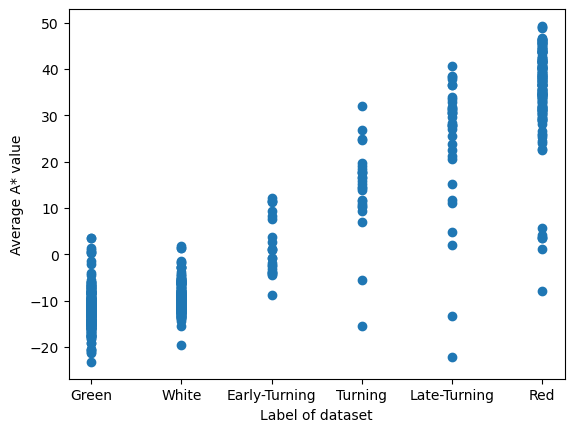

In [ ]:
ripeness_dictionary = {0:2, 1:0, 2:4, 3:5, 4:3, 5:1}
vectorized_map = np.vectorize(lambda x: ripeness_dictionary.get(x, x))
plt.scatter(vectorized_map(res_sds[:,6]),res_sds[:,21])
plt.xticks(np.arange(6),['Green', 'White', 'Early-Turning','Turning', 'Late-Turning', 'Red']);
plt.ylabel('Average A* value')
plt.xlabel('Label of dataset')

# KGCVS

In [10]:
res_kgcvs = np.load(os.path.join(basePath,'example_data/KGCVS_train.npy'))

In [11]:
loaded_colors = []
label_path = os.path.join(basePath.parent, 'Data/KGCVS/strawberry_img_tagged','maturity_labels.txt')

with open(label_path, 'r') as file:
    for line in file:
        loaded_colors.append(line.strip())

In [13]:
loaded_colors_labels = [i.split(',')[0] for i in loaded_colors]
loaded_colors_decimal = [np.float16(i.split(',')[-1]) for i in loaded_colors]

In [15]:
ripeness_dictionary = {'flower':0,\
     'green': 2,\
     'overripe': 6,\
     'red': 5,\
     'small g': 1,\
     'turning red': 4,\
     'white':3}

In [16]:
vectorized_map = [ripeness_dictionary[i] for i in loaded_colors_labels]
vectorized_map = np.array(vectorized_map)

Text(0.5, 0, 'Label of dataset')

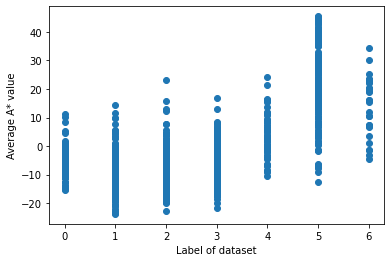

In [18]:
plt.scatter(vectorized_map,res_kgcvs[:,21])
plt.ylabel('Average A* value')
plt.xlabel('Label of dataset')

# Comparisons

Comparative illustration in the main paper

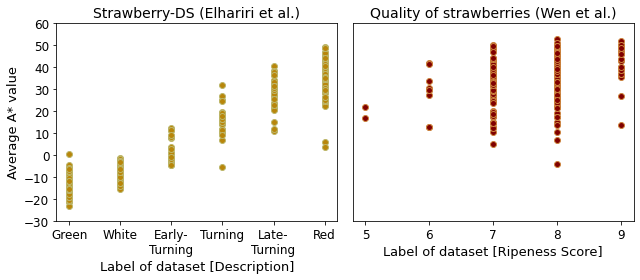

In [ ]:
plt.subplots(1,2,figsize=(9,4))

plt.subplot(1,2,1)
plt.scatter(vectorized_map(res_sds[:,6]),res_sds[:,21], color='darkgoldenrod', edgecolors='darkkhaki')
plt.yticks(fontsize=12)
plt.xticks(np.arange(6),['Green', 'White', 'Early-\nTurning','Turning', 'Late-\nTurning', 'Red'],fontsize=12);
plt.ylabel('Average A* value', fontsize=13)
plt.xlabel('Label of dataset [Description]', fontsize=13)
plt.ylim(-30,60)
plt.title('Strawberry-DS (Elhariri et al.)', fontsize=14)

plt.subplot(1,2,2)
plt.scatter(res[:,0], res[:,1], color='maroon', edgecolors='peru')
plt.xlabel('Label of dataset [Ripeness Score]', fontsize=13)
plt.yticks([],fontsize=12)
plt.xticks(np.arange(5,10),fontsize=12)
plt.ylim(-30,60)
plt.title('Quality of strawberries (Wen et al.)', fontsize=14)

plt.tight_layout()
plt.savefig('maturity_scoring.png')

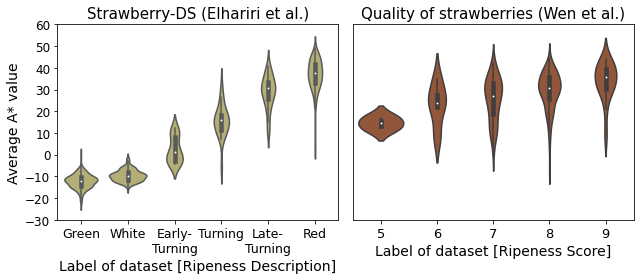

In [ ]:
plt.subplots(1,2,figsize=(9,4))

plt.subplot(1,2,1)
df = pd.DataFrame([vectorized_map(res_sds[:,6]),res_sds[:,21]]).transpose()
df.columns=['ripeness','a*']
sns.violinplot(data=df, x='ripeness', y='a*', color='darkkhaki', edgecolors='darkkhaki')
plt.xticks(np.arange(6),['Early-Turning', 'Green', 'Late-Turning', 'Red', 'Turning', 'White']);
plt.yticks(fontsize=12)
plt.xticks(np.arange(6),['Green', 'White', 'Early-\nTurning','Turning', 'Late-\nTurning', 'Red'],fontsize=12.5);
plt.ylabel('Average A* value', fontsize=14)
plt.xlabel('Label of dataset [Ripeness Description]', fontsize=14)
plt.ylim(-30,60)
plt.title('Strawberry-DS (Elhariri et al.)', fontsize=15)

plt.subplot(1,2,2)
df = pd.DataFrame([res[:,0], res[:,1]]).transpose()
df.columns=['ripeness','a*']
sns.violinplot(data=df, x='ripeness', y='a*', color='sienna', edgecolors='peru')
plt.ylabel('')
plt.xlabel('Label of dataset [Ripeness Score]', fontsize=14)
plt.yticks([],fontsize=12)
plt.xticks(np.arange(5), np.arange(5,10), fontsize=13)
plt.ylim(-30,70)
plt.title('Quality of strawberries (Wen et al.)', fontsize=15)

plt.tight_layout()
plt.savefig('maturity_scoring_violin.png')